سامانه تشخیص لبخند در ویدیو

In [17]:
import cv2 
import os
from matplotlib import pyplot as plt
import numpy as np
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from PIL import Image
from skimage.feature import hog
from skimage import data, exposure
from skimage import feature
from skimage import io
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pickle
from sklearn.metrics import roc_curve, auc

first step is Load the face detection model

In [18]:
hog_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
print(hog_face_cascade)
lbp_face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'lbpcascade_frontalface.xml')
print(lbp_face_cascade)

< cv2.CascadeClassifier 000001ECF09410F0>
< cv2.CascadeClassifier 000001ECF0941130>


In [19]:
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
print(eye_cascade)

< cv2.CascadeClassifier 000001ECDC84EF10>


The next step is Load and preprocess the input 

In [20]:

# in this step we should receive a video and then we should extract picture and then checking
# capture frames from a camera
cap = cv2.VideoCapture(0)
  
# loop runs if capturing has been initialized.
while 1: 
  
    # reads frames from a camera
    ret, image = cap.read() 
  
    # convert to gray scale of each frames
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
    # Detects faces of different sizes in the input image
    faces = hog_face_cascade.detectMultiScale(gray, 1.3, 5)
  
    for (x,y,w,h) in faces:
        # To draw a rectangle in a face 
        cv2.rectangle(image,(x,y),(x+w,y+h),(255,255,0),2) 
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = image[y:y+h, x:x+w]
  
    # Display an image in a window
    cv2.imshow('image', image)
  
    # Wait for Esc key to stop
    k = cv2.waitKey(30) & 0xff
    if k == 27:
        break
  
# Close the window
cap.release()
  
# De-allocate any associated memory usage
cv2.destroyAllWindows() 
# at first we try that on a simple picture

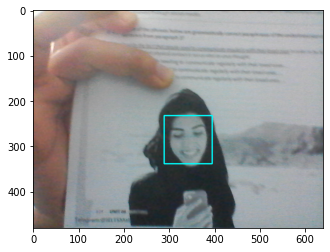

In [21]:
# display the original pic
image_show = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
plt.imshow(image_show)
plt.show()

In [22]:
# # conversion to grayscale
# gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# gray = np.array(gray, dtype='uint8')

The next step is applying face detection

In [23]:
# detect faces is grayScale image
# faces = hog_face_cascade.detectMultiScale(gray, 1.3, 5)

The next step is to Iterate over the detected faces and draw rectangles
It means that Iterate over the rectangles representing the detected faces and draw rectangles on the original image using the "cv2.rectangle" function.

In [24]:
# for (x, y, w, h) in faces:
#     cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
#     roi_gray = gray[y:y+h, x:x+w]
#     roi_color = image[y:y+h, x:x+w]

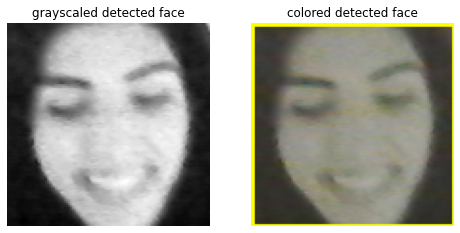

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(roi_gray, cmap=plt.cm.gray)
ax1.set_title('grayscaled detected face')

ax2.axis('off')
ax2.imshow(roi_color)
ax2.set_title('colored detected face')
plt.show()

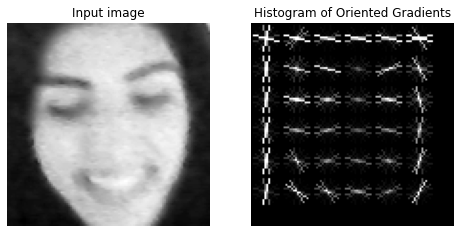

In [26]:
#creating hog features
fd, hog_image = hog(roi_color, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(roi_gray, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [27]:
# Create an LBP object
radius = 3
n_points = 8 * radius
lbp = feature.local_binary_pattern(roi_gray, n_points, radius, method='uniform')

# Calculate the histogram of LBP features
hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

# Normalize the histogram
hist = hist.astype("float")
hist /= (hist.sum() + 1e-7)

# Print the LBP histogram
print(hist)

[0.03043788 0.01548594 0.01334995 0.01388394 0.01486294 0.01824493
 0.01753293 0.01744393 0.02278391 0.03319687 0.0498398  0.08383766
 0.10430758 0.06977572 0.04396582 0.03462086 0.02331791 0.0255429
 0.01637593 0.01557494 0.01406194 0.01174795 0.01165895 0.00970096
 0.03177287 0.25667497]


Now we load our dataset

In [28]:
# Path to the directory containing the image dataset
dataset_path = 'files'

#Load our dataset of images and their corresponding labels
hog_images = []
hog_features = []

# Iterate over each file in the dataset directory
for filename in os.listdir(dataset_path):
    # Check if the file is an image file
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        # Construct the full file path
        file_path = os.path.join(dataset_path, filename)
        
        # Read the image using OpenCV
        iterate_image = cv2.imread(file_path)
        iterate_gray = cv2.cvtColor(iterate_image, cv2.COLOR_BGR2GRAY)

        iterate_faces = hog_face_cascade.detectMultiScale(iterate_gray, 1.3, 5)

        for (x,y,w,h) in iterate_faces:
            # To draw a rectangle in a face 
            cv2.rectangle(iterate_image,(x,y),(x+w,y+h),(255,255,0),2) 
            iterate_roi_gray = iterate_gray[y:y+h, x:x+w]
            iterate_roi_color = iterate_image[y:y+h, x:x+w]

            iterate_fd, iterate_hog_image = hog(iterate_roi_color, orientations=8, pixels_per_cell=(16, 16),
                    cells_per_block=(1, 1), visualize=True, channel_axis=-1)
            # Rescale histogram for better display
            # iterate_hog_image_rescaled = exposure.rescale_intensity(iterate_hog_image, in_range=(0, 10))

        hog_images.append(iterate_hog_image)
        hog_features.append(fd)
        
            # plt.subplot(1, 2, 1)
            # plt.imshow(iterate_hog_image, cmap=plt.cm.gray)
            # plt.title("hog feature")
            # plt.subplot(1, 2, 2)
            # plt.imshow(iterate_roi_gray, cmap='gray')
            # plt.title("Input image")
            # plt.show()

In [29]:
labels = []

with open('labels.txt', 'r') as file:
    for line in file:
        first_char = line[0]
        labels.append(first_char)

# Convert the list to a NumPy array
array = np.array(labels)

# # Save the array to a file
# np.save('chars.npy', chars_array)
labels =  np.array(labels).reshape(len(labels),1)

In [30]:
hog_features = np.array(hog_features)

In [31]:
clf = svm.SVC()
hog_features = np.array(hog_features)
data_frame = np.hstack((hog_features, labels))
np.random.shuffle(data_frame)

In [32]:
#What percentage of data you want to keep for training
percentage = 80
partition = int(len(hog_features)*percentage/100)

In [33]:
x_train, x_test = data_frame[:partition,:-1],  data_frame[partition:,:-1]
y_train, y_test = data_frame[:partition,-1:].ravel() , data_frame[partition:,-1:].ravel()

model = clf.fit(x_train,y_train)

In [34]:
y_pred = clf.predict(x_test)

In [35]:
print("Accuracy: "+str(accuracy_score(y_test, y_pred)))
print('\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.54375


              precision    recall  f1-score   support

           0       0.00      0.00      0.00       365
           1       0.54      1.00      0.70       435

    accuracy                           0.54       800
   macro avg       0.27      0.50      0.35       800
weighted avg       0.30      0.54      0.38       800



c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [36]:
# Save the trained model
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [37]:
# Load the saved model
with open('model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [38]:
input_test = []
input_test.append(roi_color)
input_test = np.array(input_test)
input_test = int(len(input_test))
input_test = data_frame[:input_test,:-1]

In [39]:
# Use the loaded model
predictions = loaded_model.predict(input_test)

In [1]:

print(predictions)

NameError: name 'ax1' is not defined